In [1]:
'''
目的：
安裝本 project 需要的套件：
- pandas / numpy：資料處理、運算
- sentence-transformers：embedding
- matplotlib：畫圖
- tqdm：進度條
'''
!pip -q install pandas numpy sentence-transformers matplotlib tqdm

In [2]:
'''
目的：
匯入接下來會用到的工具
'''
import re  # 文字處理
import time  # 計時（做 cost analysis）
import random  # 隨機抽樣
import numpy as np  # 向量運算
import pandas as pd  # 讀取資料
import matplotlib.pyplot as plt  # 畫圖

from tqdm import tqdm  # 進度條
from sentence_transformers import SentenceTransformer  # embedding 模型

In [3]:
'''
自動下載 DailyDialog.csv
使用 gdown 從 Google Drive public link 下載
'''

!pip install -q gdown

import gdown

file_id = "18E8I_DrPpUURcW3mv7KvQVFtheGPceYQ"

url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "DailyDialog.csv", quiet=False)

print(":) Dataset downloaded")

Downloading...
From: https://drive.google.com/uc?id=18E8I_DrPpUURcW3mv7KvQVFtheGPceYQ
To: /content/DailyDialog.csv
100%|██████████| 562k/562k [00:00<00:00, 33.8MB/s]

:) Dataset downloaded


In [4]:
'''
目的：
1) 讀取 DailyDialog.csv
2)建立 conversations：list[list[str]]

成功標準：
- Conversations built > 0
- 能印出前幾句對話
'''

df = pd.read_csv("DailyDialog.csv")  # 讀取 CSV
print(":) Loaded CSV")
print("Columns:", df.columns.tolist())

def parse_dialog_robust(x):
    # 把亂格式的對話字串解析成 list[str]
    if pd.isna(x):  # 空值
        return None  # 回 None

    s = str(x)  # 轉字串

    # 去掉外層中括號
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]

    # 把 \n 變成空白（避免干擾）
    s = s.replace("\\n", " ")

    # 抽出所有 '句子' 或 "句子"
    turns = re.findall(r"'([^']+)'|\"([^\"]+)\"", s)

    cleaned = []  # 存清理後句子
    for t in turns:  # t 是 tuple (單引號group, 雙引號group)
        sentence = t[0] if t[0] != "" else t[1]  # 選有內容那個
        sentence = sentence.strip()  # 去空白
        if sentence:  # 非空才加
            cleaned.append(sentence)

    # 至少要 2 句才算對話
    return cleaned if len(cleaned) >= 2 else None

conversations = []  # 存所有對話
for x in df["dialog"].tolist():  # 逐筆解析
    turns = parse_dialog_robust(x)  # robust 解析
    if turns is not None and len(turns) >= 4:  # 至少 4 句，才適合測記憶
        conversations.append(turns)

print(":) Conversations built:", len(conversations))

if len(conversations) > 0:
    print("\nExample (first 8 turns):")
    for i, utt in enumerate(conversations[0][:8]):
        print(f"{i+1}: {utt}")

:) Loaded CSV
Columns: ['dialog', 'act', 'emotion']
:) Conversations built: 918

Example (first 8 turns):
1: Hey man , you wanna buy some weed ?
2: Some what ?
3: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !
4: Oh , umm , no thanks .
5: I also have blow if you prefer to do a few lines .
6: No , I am ok , really .
7: Come on man ! I even got dope and acid ! Try some !
8: Do you really have all of these drugs ? Where do you get them from ?


In [5]:
'''
目的：
載入 embedding 模型，把句子變成向量，用 cosine similarity 做 retrieval
第一次會下載模型，正常
'''
embedder = SentenceTransformer("all-MiniLM-L6-v2")
print(":) Embedder loaded")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


:) Embedder loaded


In [6]:
'''
目的：
從真實對話中自動產生「記憶測試題」
- 取早期一句話 target
- 抽 keyword
- 在最後問：Earlier, you mentioned '<keyword>'. What did you say?
- 4 選 1：正確答案 = target
'''

STOPWORDS = set([
    "the","a","an","and","or","but","to","of","in","on","at","for","with","is","am","are","was","were",
    "i","you","he","she","it","we","they","my","your","his","her","their","our","me","him","them",
    "this","that","these","those","do","does","did","done","not","no","yes","what","why","how","when","where",
    "be","been","being","have","has","had","will","would","can","could","should","may","might","must",
])

def extract_keyword(sentence):
    # 從句子抽 keyword（避開停用字）
    words = re.findall(r"[A-Za-z]+", sentence.lower())  # 抓英文字
    words = [w for w in words if w not in STOPWORDS and len(w) >= 4]  # 去停用字 + 太短
    if len(words) == 0:
        return None
    words.sort(key=len, reverse=True)  # 用最長的字當 keyword（通常更有意義）
    return words[0]

all_utterances = []  # distractor 池
for conv in conversations:
    for utt in conv:
        all_utterances.append(utt)

def build_one_mcq_test(conv):
    # 從一段 conv 建一題 MCQ
    max_pick = max(2, int(len(conv) * 0.4))  # 前 40% 抽 target（更像「很久以前」）
    idx = random.randint(1, max_pick)  # 隨機挑一句
    target = conv[idx]  # 要記住的句子

    keyword = extract_keyword(target)  # 抽 keyword
    if keyword is None:
        return None

    question = f"Earlier, you mentioned '{keyword}'. What did you say?"

    options = [target]  # 正確答案先放進去
    while len(options) < 4:  # 補 3 個錯誤選項
        cand = random.choice(all_utterances)
        if cand != target and cand not in options:
            options.append(cand)
    random.shuffle(options)  # 打亂

    correct_index = options.index(target)  # 正確位置

    full_dialog = ["User: " + u for u in conv]  # 組成對話
    full_dialog.append("User: " + question)  # 最後加問題

    return {
        "keyword": keyword,
        "target": target,
        "question": question,
        "options": options,
        "correct_index": correct_index,
        "full_dialog": full_dialog,
        "target_turn_index": idx
    }

random.seed(42)

NUM_TESTS = 60
tests = []

while len(tests) < NUM_TESTS:
    conv = random.choice(conversations)
    t = build_one_mcq_test(conv)
    if t is not None:
        tests.append(t)

print(":) Tests built:", len(tests))

ex = tests[0]
print("\n=== Example test ===")
print("Keyword:", ex["keyword"])
print("Question:", ex["question"])
print("Target:", ex["target"])
print("\nOptions:")
for i, opt in enumerate(ex["options"]):
    print(f"{chr(65+i)}. {opt}")

:) Tests built: 60

=== Example test ===
Keyword: finish
Question: Earlier, you mentioned 'finish'. What did you say?
Target: I'm very busy these days . It seems I can never finish my work .

Options:
A. I'm a little rushed . Is there any quicker way to get there ?
B. Then you must know Shen Due and Hao Hongbo .
C. I'm very busy these days . It seems I can never finish my work .
D. l'm sorry . All the black of that size are sold out . Would you like a red one ?


In [7]:
'''
目的：
1) cosine similarity
2) 簡易 token 計算（用 word count 近似，做 efficiency analysis）
3) 用 embedding 選 MCQ 答案
'''

def cosine_sim(a, b):
    # cosine similarity
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def approx_tokens(text):
    # 粗略 token：用空白切 word count 當近似（夠用來做效率比較）
    return len(str(text).split())

def pick_option_by_embedding(query_text, options):
    # 用 embedding 選最相似的選項
    q_emb = embedder.encode(query_text)  # query embedding
    opt_embs = embedder.encode(options)  # options embedding
    scores = [cosine_sim(q_emb, opt_embs[i]) for i in range(len(options))]
    best = int(np.argmax(scores))
    return best, scores

In [8]:
'''
目的：
建立「雙記憶架構」代理（Bio-inspired Dual Memory）

設計理念：
- Short-term memory (STM)：最近 K 句（sliding window）
- Long-term memory (LTM)：把所有句子存成可檢索記憶庫
- Memory strength（記憶強度）模仿人類：
  1) frequency 高 → strength 高
  2) retrieval 成功 → strength 增加（consolidation）
  3) 很久沒用 → strength 衰減（decay）
'''

class DualMemoryAgent:
    def __init__(self, embedder, stm_k=6, decay_lambda=0.02, boost_on_retrieval=0.8, boost_on_store=0.2):
        # 保存 embedding 模型
        self.embedder = embedder

        # STM（短期記憶）最多保留幾句
        self.stm_k = stm_k

        # 記憶衰減速度（越大忘越快）
        self.decay_lambda = decay_lambda

        # retrieval 成功時的強化幅度
        self.boost_on_retrieval = boost_on_retrieval

        # 每次存入記憶的小幅增強（frequency）
        self.boost_on_store = boost_on_store

        # short_term_memory：存最近對話句子（list[str]）
        self.short_term_memory = []

        # long_term_memory：每筆記憶包含文字與強度資訊
        # 格式：dict(text, emb, strength, freq, created_step, last_used_step)
        self.long_term_memory = []

        # 用 step 當作時間（每處理一個 turn step += 1）
        self.step = 0

        # 用來做 cost analysis：統計 similarity 次數
        self.sim_ops = 0

    def reset(self):
        # 重置 agent（跑新題目時用）
        self.short_term_memory = []
        self.long_term_memory = []
        self.step = 0
        self.sim_ops = 0

    def _decayed_strength(self, mem):
        # 計算衰減後的強度：strength * exp(-lambda * time_gap)
        gap = self.step - mem["last_used_step"]
        return mem["strength"] * float(np.exp(-self.decay_lambda * gap))

    def store_turn(self, utterance):
        # 每加入一個對話句子，就更新 step
        self.step += 1

        # 1) 更新 STM：只保留最近 stm_k 句
        self.short_term_memory.append(utterance)
        if len(self.short_term_memory) > self.stm_k:
            self.short_term_memory = self.short_term_memory[-self.stm_k:]

        # 2) 更新 LTM：如果句子已存在→freq+1，strength+；不存在→新增
        #    這對應「出現頻率高 → 記憶強度高」
        for mem in self.long_term_memory:
            if mem["text"] == utterance:
                mem["freq"] += 1
                mem["strength"] += self.boost_on_store
                return

        emb = self.embedder.encode(utterance)
        self.long_term_memory.append({
            "text": utterance,
            "emb": emb,
            "strength": 1.0,  # 初始強度
            "freq": 1,
            "created_step": self.step,
            "last_used_step": self.step
        })

    def retrieve(self, query, topk=1):
        # 從 LTM 找最相關記憶（embedding similarity）
        if len(self.long_term_memory) == 0:
            return []

        q_emb = self.embedder.encode(query)

        scored = []
        for mem in self.long_term_memory:
            # cosine sim
            sim = cosine_sim(q_emb, mem["emb"])
            self.sim_ops += 1  # 計算一次 similarity operation

            # 加入衰減後強度（human-like memory）
            s = self._decayed_strength(mem)

            # 最終分數：相似度 * (1 + 強度)
            score = sim * (1.0 + s)
            scored.append((score, mem))

        scored.sort(key=lambda x: x[0], reverse=True)
        top = scored[:topk]

        # 更新 last_used（代表「被使用過」）
        for _, mem in top:
            mem["last_used_step"] = self.step

        return [mem["text"] for _, mem in top]

    def consolidate(self, retrieved_text):
        # retrieval 成功時，把該記憶強化（consolidation）
        for mem in self.long_term_memory:
            if mem["text"] == retrieved_text:
                mem["strength"] += self.boost_on_retrieval
                mem["freq"] += 1
                mem["last_used_step"] = self.step
                return

    def answer_mcq(self, question, options, use_retrieval=True, ret_topk=1):
        # 用 STM + (可選) retrieval memory 來回答 MCQ

        # 1) STM context
        context_text = "\n".join(self.short_term_memory)

        # 2) retrieval
        retrieved_list = []
        if use_retrieval:
            retrieved_list = self.retrieve(question, topk=ret_topk)

        # 3) 組 query（模擬 prompt）
        if use_retrieval and len(retrieved_list) > 0:
            retrieved_block = "\n".join([f"- {r}" for r in retrieved_list])
            query = f"Retrieved memory:\n{retrieved_block}\n\nQuestion:\n{question}\n\nContext:\n{context_text}"
        else:
            query = f"Question:\n{question}\n\nContext:\n{context_text}"

        # 4) embedding 選答案
        pred_idx, scores = pick_option_by_embedding(query, options)

        # 5) 回傳結果（包含 query token、retrieval token）
        info = {
            "retrieved": retrieved_list,
            "query_tokens": approx_tokens(query),
            "stm_tokens": approx_tokens(context_text),
            "scores": scores
        }
        return pred_idx, info

In [9]:
'''
目的：
定義兩種系統，用來做曲線比較：
1) Sliding Window baseline（只用 STM，不用 LTM）
2) DualMemoryAgent（STM + LTM retrieval + consolidation）
'''

def run_one_test_sliding(test, k):
    # 只用 sliding window：取最後 k-1 句（因為最後一句是問題）
    dialog_turns = test["full_dialog"][:-1]  # 問題之前的所有句子
    stm = dialog_turns[-k:]  # 最後 k 句當 context
    context_text = "\n".join(stm)

    query = test["question"] + "\nContext:\n" + context_text
    pred_idx, _ = pick_option_by_embedding(query, test["options"])

    # token 近似
    tokens = approx_tokens(query)
    return pred_idx, {"tokens": tokens}

def run_one_test_dualmemory(test, stm_k, ret_topk=1):
    # DualMemoryAgent：逐句 store → 最後回答 → consolidation
    agent = DualMemoryAgent(
        embedder=embedder,
        stm_k=stm_k,
        decay_lambda=0.02,
        boost_on_retrieval=0.8,
        boost_on_store=0.15
    )
    agent.reset()

    # 把問題前的句子逐句存入記憶
    for utt in test["full_dialog"][:-1]:
        agent.store_turn(utt)

    # 回答 MCQ（用 retrieval）
    t0 = time.time()
    pred_idx, info = agent.answer_mcq(test["question"], test["options"], use_retrieval=True, ret_topk=ret_topk)
    t1 = time.time()

    # consolidation：如果真的有 retrieve 到東西，就把第一個 retrieved 強化
    if len(info["retrieved"]) > 0:
        agent.consolidate(info["retrieved"][0])

    # cost metrics
    elapsed_ms = (t1 - t0) * 1000.0

    # 估算 retrieval “計算量” = sim_ops（越大越慢）
    sim_ops = agent.sim_ops

    return pred_idx, {
        "tokens": info["query_tokens"],
        "retrieved": info["retrieved"],
        "elapsed_ms": elapsed_ms,
        "sim_ops": sim_ops
    }

In [10]:
'''
目的：
做三種分析：

(1) Accuracy vs Context Length
    - Sliding baseline：k = 2,4,6,8,10,12
    - DualMemory：stm_k = 2,4,6,8,10,12（但會額外 retrieval）

(2) Accuracy per token
    - 將每種 k 的平均 token 計算出來
    - 看「同樣準確率」誰用更少 token

(3) Retrieval cost vs performance
    - DualMemory 每個 k 的平均 elapsed_ms（時間）
    - 平均 sim_ops（相似度計算次數）
'''

K_LIST = [2, 4, 6, 8, 10, 12]  # 曲線點
RET_TOPK = 1  # retrieve 幾條記憶（1 最省時間，也最清楚）

curve = []  # 存每個 k 的結果（最後會轉成 dataframe）

for k in K_LIST:
    # ---- Sliding baseline ----
    correct_slide = 0
    token_slide_sum = 0

    # ---- DualMemory ----
    correct_dual = 0
    token_dual_sum = 0
    ms_dual_sum = 0.0
    simops_dual_sum = 0

    for t in tqdm(tests, desc=f"Running k={k}", leave=False):
        # sliding
        pred_s, info_s = run_one_test_sliding(t, k=k)
        ok_s = (pred_s == t["correct_index"])
        correct_slide += int(ok_s)
        token_slide_sum += info_s["tokens"]

        # dual
        pred_d, info_d = run_one_test_dualmemory(t, stm_k=k, ret_topk=RET_TOPK)
        ok_d = (pred_d == t["correct_index"])
        correct_dual += int(ok_d)
        token_dual_sum += info_d["tokens"]
        ms_dual_sum += info_d["elapsed_ms"]
        simops_dual_sum += info_d["sim_ops"]

    n = len(tests)

    acc_slide = correct_slide / n
    acc_dual = correct_dual / n

    avg_tok_slide = token_slide_sum / n
    avg_tok_dual = token_dual_sum / n

    # accuracy per token（越大越好：用更少 token 達到更高 accuracy）
    apt_slide = acc_slide / avg_tok_slide
    apt_dual = acc_dual / avg_tok_dual

    avg_ms_dual = ms_dual_sum / n
    avg_simops_dual = simops_dual_sum / n

    curve.append({
        "k": k,
        "acc_sliding": acc_slide,
        "acc_dualmemory": acc_dual,
        "avg_tokens_sliding": avg_tok_slide,
        "avg_tokens_dualmemory": avg_tok_dual,
        "acc_per_token_sliding": apt_slide,
        "acc_per_token_dualmemory": apt_dual,
        "avg_retrieval_ms_dualmemory": avg_ms_dual,
        "avg_simops_dualmemory": avg_simops_dual
    })

curve_df = pd.DataFrame(curve)
print(curve_df)

    k  acc_sliding  acc_dualmemory  avg_tokens_sliding  avg_tokens_dualmemory  \
0   2     0.933333        0.950000           41.633333              60.616667   
1   4     0.966667        0.950000           78.466667              97.450000   
2   6     0.950000        0.983333          102.233333             121.216667   
3   8     0.950000        0.966667          117.750000             136.733333   
4  10     0.950000        0.966667          127.716667             146.700000   
5  12     0.966667        0.983333          133.683333             152.666667   

   acc_per_token_sliding  acc_per_token_dualmemory  \
0               0.022418                  0.015672   
1               0.012319                  0.009749   
2               0.009292                  0.008112   
3               0.008068                  0.007070   
4               0.007438                  0.006589   
5               0.007231                  0.006441   

   avg_retrieval_ms_dualmemory  avg_simops_dualmemory

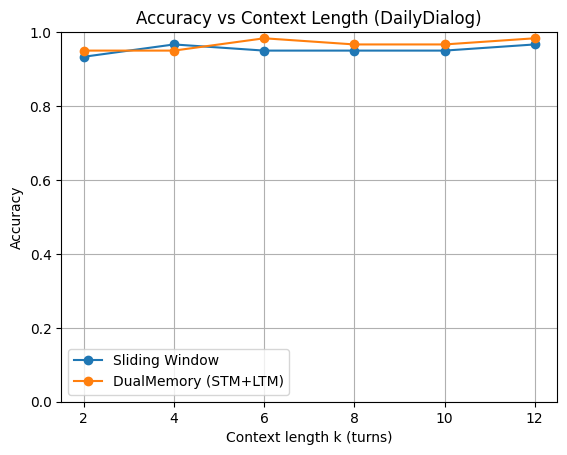

:) Saved: curve_accuracy.png


In [11]:
'''
目的：
畫 Accuracy vs Context Length 曲線
'''

plt.figure()
plt.plot(curve_df["k"], curve_df["acc_sliding"], marker="o", label="Sliding Window")
plt.plot(curve_df["k"], curve_df["acc_dualmemory"], marker="o", label="DualMemory (STM+LTM)")
plt.ylim(0, 1)
plt.xlabel("Context length k (turns)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Context Length (DailyDialog)")
plt.legend()
plt.grid(True)
plt.savefig("curve_accuracy.png", dpi=200)
plt.show()

print(":) Saved: curve_accuracy.png")

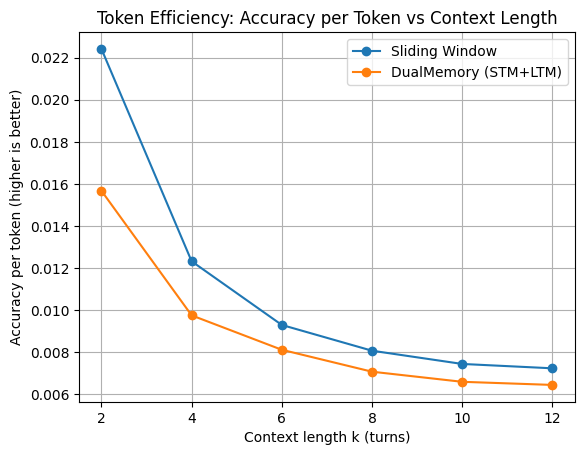

:) Saved: curve_efficiency.png


In [12]:
'''
目的：
畫 Accuracy per token 曲線
'''

plt.figure()
plt.plot(curve_df["k"], curve_df["acc_per_token_sliding"], marker="o", label="Sliding Window")
plt.plot(curve_df["k"], curve_df["acc_per_token_dualmemory"], marker="o", label="DualMemory (STM+LTM)")
plt.xlabel("Context length k (turns)")
plt.ylabel("Accuracy per token (higher is better)")
plt.title("Token Efficiency: Accuracy per Token vs Context Length")
plt.legend()
plt.grid(True)
plt.savefig("curve_efficiency.png", dpi=200)
plt.show()

print(":) Saved: curve_efficiency.png")

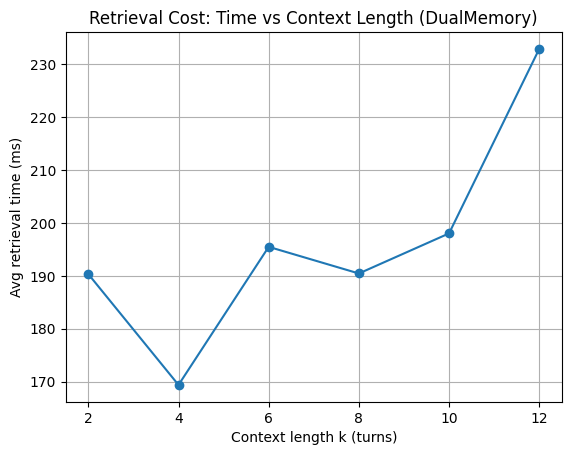

:) Saved: curve_cost.png


In [13]:
'''
目的：
畫 DualMemory 的 retrieval cost vs performance
兩個 cost：
1) avg_retrieval_ms_dualmemory：平均耗時
2) avg_simops_dualmemory：平均相似度運算次數（向量庫越大越多）
'''

plt.figure()
plt.plot(curve_df["k"], curve_df["avg_retrieval_ms_dualmemory"], marker="o")
plt.xlabel("Context length k (turns)")
plt.ylabel("Avg retrieval time (ms)")
plt.title("Retrieval Cost: Time vs Context Length (DualMemory)")
plt.grid(True)
plt.savefig("curve_cost.png", dpi=200)
plt.show()

print(":) Saved: curve_cost.png")

In [14]:
'''
輸出：
1) curve_results.csv：曲線的表格數據
2) results_dualmemory.csv：每題明細
'''

# 存曲線資料
curve_df.to_csv("curve_results.csv", index=False)
print(":) Saved: curve_results.csv")

# 再跑一次「單一設定」輸出每題結果
FINAL_K = 6  # 可以改成 4 或 6，通常最能顯示 DualMemory 的價值

records = []
for i, t in enumerate(tests, start=1):
    pred_s, info_s = run_one_test_sliding(t, k=FINAL_K)
    ok_s = (pred_s == t["correct_index"])

    pred_d, info_d = run_one_test_dualmemory(t, stm_k=FINAL_K, ret_topk=1)
    ok_d = (pred_d == t["correct_index"])

    records.append({
        "id": i,
        "k": FINAL_K,
        "keyword": t["keyword"],
        "question": t["question"],
        "correct_letter": chr(65 + t["correct_index"]),
        "sliding_pred": chr(65 + pred_s),
        "dualmemory_pred": chr(65 + pred_d),
        "sliding_ok": ok_s,
        "dualmemory_ok": ok_d,
        "sliding_tokens": info_s["tokens"],
        "dualmemory_tokens": info_d["tokens"],
        "retrieved_memory": " | ".join(info_d["retrieved"]) if len(info_d["retrieved"]) > 0 else "",
        "retrieval_ms": info_d["elapsed_ms"],
        "sim_ops": info_d["sim_ops"],
        "ground_truth_sentence": t["target"]
    })

results_df = pd.DataFrame(records)
results_df.to_csv("results_dualmemory.csv", index=False)
print(":) Saved: results_dualmemory.csv")
print(results_df.head())

:) Saved: curve_results.csv
:) Saved: results_dualmemory.csv
   id  k       keyword                                           question  \
0   1  6        finish  Earlier, you mentioned 'finish'. What did you ...   
1   2  6          like   Earlier, you mentioned 'like'. What did you say?   
2   3  6  typographers  Earlier, you mentioned 'typographers'. What di...   
3   4  6        please  Earlier, you mentioned 'please'. What did you ...   
4   5  6         about  Earlier, you mentioned 'about'. What did you say?   

  correct_letter sliding_pred dualmemory_pred  sliding_ok  dualmemory_ok  \
0              C            C               C        True           True   
1              D            D               D        True           True   
2              D            D               D        True           True   
3              A            A               A        True           True   
4              A            A               A        True           True   

   sliding_tokens  

In [15]:
'''
目的：
下載成果檔案
'''
from google.colab import files

files.download("curve_accuracy.png")
files.download("curve_efficiency.png")
files.download("curve_cost.png")
files.download("curve_results.csv")
files.download("results_dualmemory.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>